In [1]:
import cv2
import easyocr
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.117 🚀 Python-3.9.13 torch-2.0.1+cu117 CPU
Setup complete ✅ (4 CPUs, 3.7 GB RAM, 90.4/233.2 GB disk)


In [3]:
from ultralytics import YOLO

from IPython.display import display, Image

In [4]:
# load an pretrained model
model = YOLO('best.pt') 
model.conf = 0.4  #confidence threshold for detection

In [19]:
def preprocess_image(image):
    # Convert to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Display the grayscale image
    display(Image(data=cv2.imencode('.jpg',grayscale_image)[1].tobytes()))
    #gaussian blur
    blur= cv2.GaussianBlur(grayscale_image,(5,5),0)
    #thesholding
    ret, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    #create rrectangular kernel for dilation
    rect_kern =cv2.getStructuringElement(cv2.MORPH_RECT ,(5,5))
    #apply dilation
    dialtion=cv2.dilate(threshold_image, rect_kern, iterations =1)
# #     # Apply denoising filter
#     denoised_image = cv2.GaussianBlur(grayscale_image, (3, 3), 0)
# #     # Apply contrast enhancement
# #     equalized_image = cv2.equalizeHist(denoised_image)
# #     # Display the preprocessed image
#     display(Image(data=cv2.imencode('.jpg', equalized_image)[1].tobytes()))
# #     # Apply image sharpening
#     sharpened_image = cv2.filter2D(equalized_image, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
# #     # Display the preprocessed image
#     display(Image(data=cv2.imencode('.jpg', sharpened_image)[1].tobytes()))
    
    return grayscale_image


  
   

In [20]:
# def threshold(image):
#     # Apply Otsu thresholding
#     _, threshold_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
#     # Display the threshold image
#     display(Image(data=cv2.imencode('.jpg',threshold_image)[1].tobytes()))
#     return threshold_image

In [26]:

def segment_characters(image):
    contours, hierarchy= cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #sort the contours left to right
    sorted_contours= sorted(contours, key=lambda ctr:cv2.boundingRect(ctr)[0])
#     for cnt in soerted_contours:
#         x,y,w,h = cv2.boundingrect(cnt)
#         height, width= im2.shape
#         #if height of height is not tall enough the skip
#         if height / float(h)> 4: continue
#             ratio
        
#         #if height to width ratio is less than 1.5 skip
    return sorted_contours

In [27]:
def ocrImage(image):
    # Perform OCR on the thresholded image
    recognized_plates=[]
    reader = easyocr.Reader(['en', 'ne'])
    result = reader.readtext(image, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ ', detail=0)
    recognized_plates = [''.join(result)]
    return recognized_plates
    

In [28]:
# def apply_ocr_to_characters(preprocessed_image, segmented_characters):
#     # Initialize EasyOCR reader
#     reader = easyocr.Reader(['en'])  # Specify the languages you want to recognize

#     # List to store the recognized characters
#     recognized_characters = []

#     # Iterate through the segmented characters
#     for rect in segmented_characters:
#         x, y, w, h = rect

#         # Extract the character region from the preprocessed image
#         character_region = preprocessed_image[y:y+h, x:x+w]

#         # Perform OCR on the character region
#         result = reader.readtext(character_region)

#         # Retrieve the recognized character
#         character = result[0][1] if len(result) > 0 else None

#         # Add the recognized character to the list
#         recognized_characters.append(character)

#     return recognized_characters

In [31]:
def recognize_number_plate(image_path,  scale_factor=3):
    vehicle_image = cv2.imread(image_path)
    # Perform object detection using YOLO
    detections = model(vehicle_image)


    # Extract bounding boxes and crop number plate regions
    number_plate_box = None
    for detection in detections[0].boxes.data:
        if detection[5] == 0:  
            number_plate_box = detection[:4]
            break  
            
#      Draw bounding box on the original image
    if number_plate_box is not None:
        x1, y1, x2, y2 = number_plate_box
        cv2.rectangle(vehicle_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
    # Display the original image with bounding box
    display(Image(data=cv2.imencode('.jpg', vehicle_image)[1].tobytes()))
    
    # Crop and Preprocess the number plate region
    if number_plate_box is not None:
        # Crop the number plate region
        cropped_image = vehicle_image[int(y1):int(y2), int(x1):int(x2)]
        # Display the cropped image
        display(Image(data=cv2.imencode('.jpg', cropped_image)[1].tobytes()))
        
         # Scale the cropped image
        scaled_image = cv2.resize(cropped_image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
        # Display the scaled image
        display(Image(data=cv2.imencode('.jpg', scaled_image)[1].tobytes()))
        
        preprocess= preprocess_image(scaled_image)
        segment=segment_characters(preprocess)
#         ocr=apply_ocr_to_characters(preprocess, segment)
        
    else:
        print("Number plate not found.")
        
    return segment



0: 544x800 1 License-plate, 445.9ms
Speed: 6.7ms preprocess, 445.9ms inference, 0.9ms postprocess per image at shape (1, 3, 800, 800)


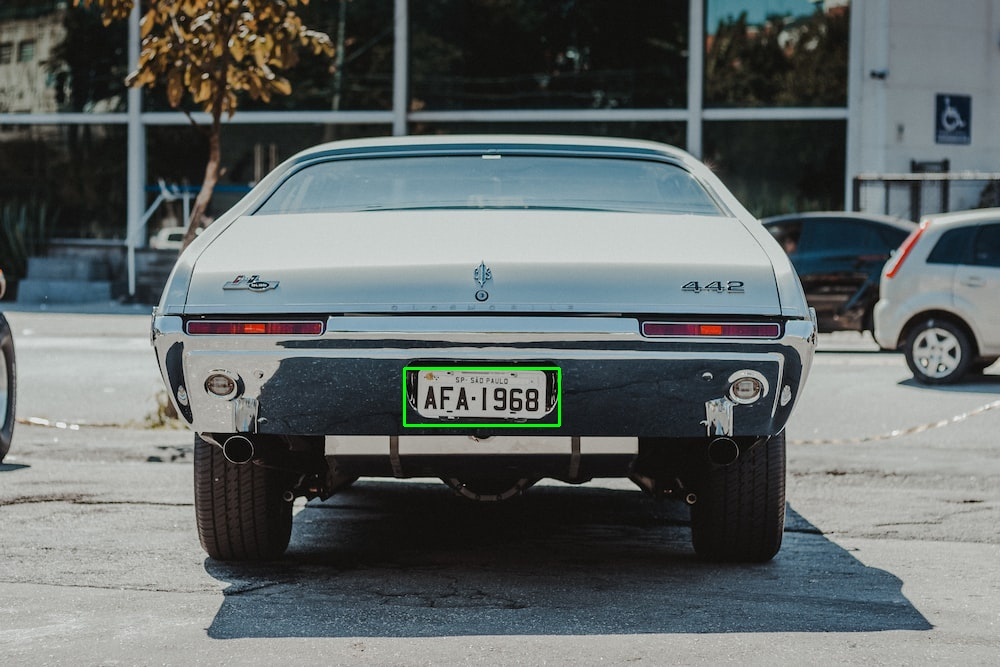

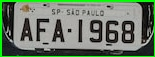

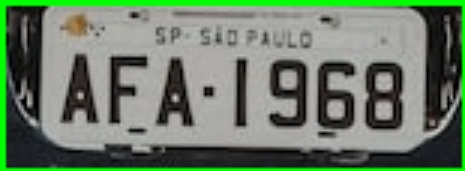

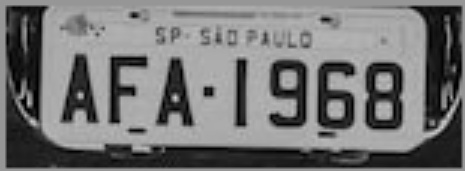

In [32]:
# Path to the image  
# image_path = '/Desktop/final%20project/kk.jpeg'
image_path = 'test_img/12.jpeg'
Image(image_path)
# Recognize the number plate
recognized_plate = recognize_number_plate(image_path)





In [ ]:
# Print the recognized number plates
for plate in recognized_plate:
    print(plate)